Implemented By Muhammad Hanan Asghar.
Github: https://github.com/MuhammadHananAsghar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/data_animals.zip"

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 112kB 9.6MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [ ]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs as tfjs

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
batch_size = 18
img_height = 70
img_width = 70

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/data/train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4498 files belonging to 10 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/data/valid",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 10 classes.


In [ ]:
class_names = train_ds.class_names
num_classes =len(class_names)
print(class_names)

['bear', 'fox', 'frog', 'horse', 'lion', 'panda', 'rhino', 'shark', 'snake', 'turtle']


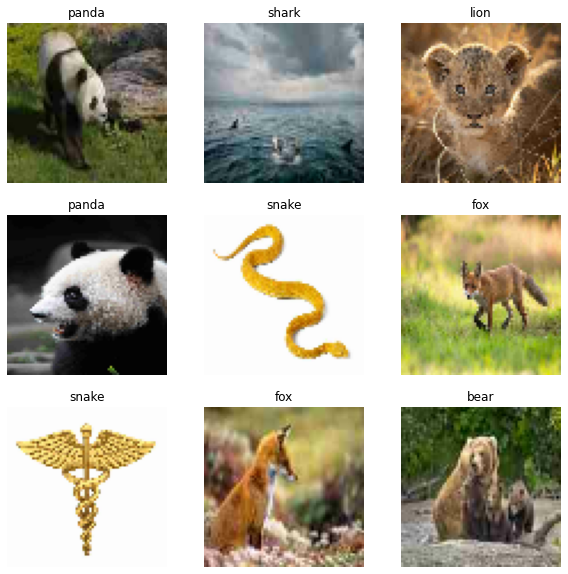

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model_animals_classification.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/100
250/250 [==============================] - 12s 10ms/step - loss: 2.1022 - accuracy: 0.2350 - val_loss: 1.8715 - val_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.87145, saving model to model_animals_classification.h5
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 1.7531 - accuracy: 0.3802 - val_loss: 1.6182 - val_accuracy: 0.4280

Epoch 00002: val_loss improved from 1.87145 to 1.61816, saving model to model_animals_classification.h5
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 1.4906 - accuracy: 0.4822 - val_loss: 1.4367 - val_accuracy: 0.5120

Epoch 00003: val_loss improved from 1.61816 to 1.43671, saving model to model_animals_classification.h5
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 1.2653 - accuracy: 0.5562 - val_loss: 1.3633 - val_accuracy: 0.5100

Epoch 00004: val_loss improved from 1.43671 to 1.36332, saving model to model_animals_classification.h5
Epoch 5/10

In [ ]:
tfjs.converters.save_keras_model(model, "/content")

In [ ]:
model_json = model.to_json()
with open("model_keras.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_keras.h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

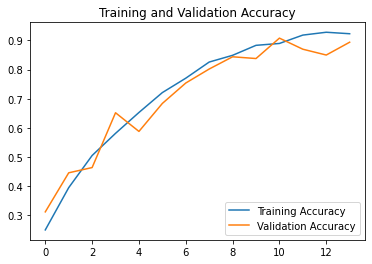

In [ ]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

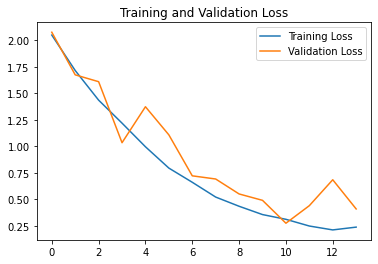

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

221184/215129 [==============================] - 0s 0us/step
This image most likely belongs to bear with a 94.43 percent confidence.


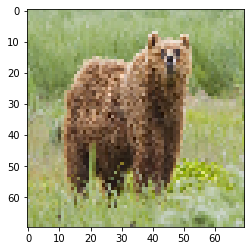

In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/2010-kodiak-bear-1.jpg/1200px-2010-kodiak-bear-1.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1646592/1644619 [==============================] - 0s 0us/step
This image most likely belongs to bear with a 99.95 percent confidence.


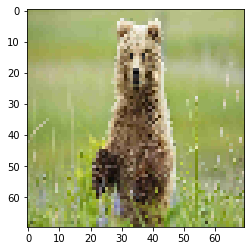

In [ ]:
image_url = "https://video.cgtn.com/news/7a596a4e784d544e33516a4d77457a4e786b444f31457a6333566d54/video/f4f4d4a40e0743b1a1e347ab0dbe6085/f4f4d4a40e0743b1a1e347ab0dbe6085.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

966656/965048 [==============================] - 0s 0us/step
This image most likely belongs to fox with a 76.68 percent confidence.


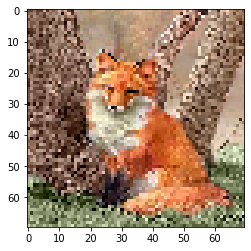

In [ ]:
image_url = "https://i.pinimg.com/originals/49/c4/31/49c4313a948e56a7cee82334d5b4e95f.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1703936/1699623 [==============================] - 0s 0us/step
This image most likely belongs to frog with a 98.48 percent confidence.


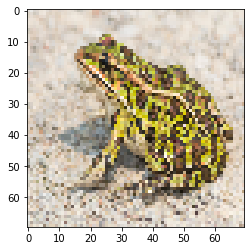

In [ ]:
image_url = "https://static.scientificamerican.com/sciam/cache/file/41DF7DA0-EE58-4259-AA815A390FB37C55_source.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

475136/468486 [==============================] - 0s 1us/step
This image most likely belongs to horse with a 100.00 percent confidence.


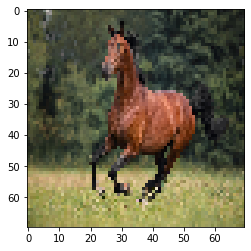

In [ ]:
image_url = "https://theplaidhorse.s3.amazonaws.com/media/uploads/2020/08/AdobeStock_326500445-1-scaled.jpeg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

737280/733213 [==============================] - 0s 0us/step
This image most likely belongs to lion with a 79.26 percent confidence.


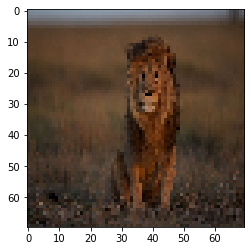

In [ ]:
image_url = "https://i.natgeofe.com/n/80b97fe3-c0fb-40a6-a6a6-88b5c3bb9d30/01-lion-populations-nationalgeographic_1777804.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

81920/77930 [===============================] - 0s 6us/step
This image most likely belongs to turtle with a 100.00 percent confidence.


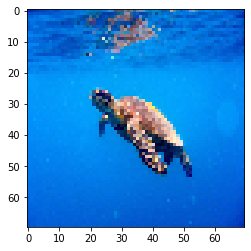

In [ ]:
image_url = "https://www.insureandgo.com.au/images/1905-header-world-turtle-day-797x57px_tcm1005-547715.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

90112/83875 [================================] - 0s 0us/step
This image most likely belongs to shark with a 99.99 percent confidence.


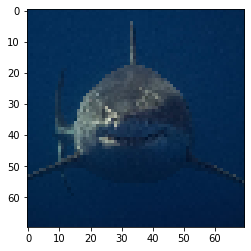

In [ ]:
image_url = "https://i.guim.co.uk/img/media/8e1efe9156048734db588b6f224db1457789fd4a/0_256_6207_3724/master/6207.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=a43dca7ea34ebf7728559d85b9a24927"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

57344/49460 [==================================] - 0s 0us/step
This image most likely belongs to panda with a 99.76 percent confidence.


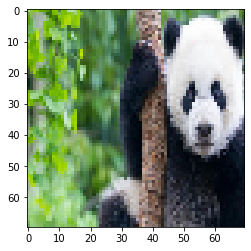

In [ ]:
image_url = "https://lh3.googleusercontent.com/proxy/n3Q1LawpiocjZsIqfLZUAiOHRMiPof1dOOPjcj0QQnQUGdYsOcR5FkzT2jBSk-20VW4WN9_HBDeYYJt4QapJp7u_wV34rfspRLj0FyAmtqzKGzFnhNulOqDadaCxHXvbG0saVuUh0eF6GwDvqFODicWJrRmLnLzR63u1"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

835584/830107 [==============================] - 0s 0us/step
This image most likely belongs to rhino with a 99.94 percent confidence.


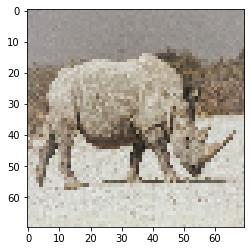

In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/4/4f/Rhino_%28234581759%29.jpeg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

90112/88643 [==============================] - 0s 0us/step
This image most likely belongs to snake with a 98.24 percent confidence.


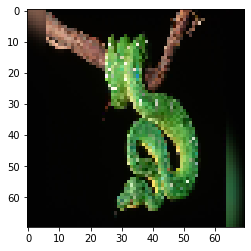

In [ ]:
image_url = "https://cdn.mos.cms.futurecdn.net/fM5sEN6qJUbCESCNZvg56n-1200-80.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path)

In [ ]:
! tensorflowjs_converter --input_format=keras {saved_model_path} "./"


2021-05-28 13:45:56.158339: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
!tensorflowjs_converter --input_format keras --output_format=tfjs_graph_model "/content/my_model.h5" "/content"

2021-05-28 13:50:17.565835: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-28 13:50:18.881328: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-28 13:50:18.886844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-28 13:50:18.887391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-05-28 13:50:18.887429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-28 13:50:18.893358: I tensorflow/stream_executor/platform/default